In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/bigmlcom/python/master/data/spam.csv"

df = pd.read_csv(url, sep="\t")
df.head(5)

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Type').describe()

Message                                                               
       count unique                                                top freq
Type                                                                       
ham      577    568                             Sorry, I'll call later    5
spam      79     79  Free entry in 2 a wkly comp to win FA Cup fina...    1

In [4]:
df_spam = df[df['Type']=='spam']
df_spam.shape

(79, 2)

In [5]:
df_ham = df[df['Type']=='ham']
df_ham.shape

(577, 2)

In [6]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(79, 2)

In [7]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(158, 2)

In [8]:
df_balanced['Type'].value_counts()

ham     79
spam    79
Name: Type, dtype: int64

In [9]:
df_balanced['spam']=df_balanced['Type'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Type,Message,spam
638,spam,Had your contract mobile 11 Mnths? Latest Moto...,1
339,spam,Double your mins & txts on Orange or 1/2 price...,1
631,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
266,ham,Haha i think i did too,0
573,spam,URGENT We are trying to contact you Last weeke...,1


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [11]:
X_train.head(4)

348    Download as many ringtones as u like no restri...
216    You have WON a guaranteed £1000 cash or a £200...
284    Alex knows a guy who sells mids but he's down ...
638    Had your contract mobile 11 Mnths? Latest Moto...
Name: Message, dtype: object

In [12]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [13]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.5132727 , -0.8884573 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.9444669 , ..., -0.85847497,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

In [18]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)


In [19]:
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
4/4 [==============================] - 26s 5s/step - loss: 0.6779 - accuracy: 0.5254 - precision: 0.5224 - recall: 0.5932
Epoch 2/10
4/4 [==============================] - 20s 5s/step - loss: 0.6543 - accuracy: 0.6441 - precision: 0.6491 - recall: 0.6271
Epoch 3/10
4/4 [==============================] - 20s 5s/step - loss: 0.6212 - accuracy: 0.6610 - precision: 0.6863 - recall: 0.5932
Epoch 4/10
4/4 [==============================] - 20s 5s/step - loss: 0.6421 - accuracy: 0.6610 - precision: 0.6557 - recall: 0.6780
Epoch 5/10
4/4 [==============================] - 20s 5s/step - loss: 0.6049 - accuracy: 0.7119 - precision: 0.6761 - recall: 0.8136
Epoch 6/10
4/4 [==============================] - 20s 5s/step - loss: 0.6085 - accuracy: 0.7119 - precision: 0.6984 - recall: 0.7458
Epoch 7/10
4/4 [==============================] - 20s 5s/step - loss: 0.5809 - accuracy: 0.7542 - precision: 0.8000 - recall: 0.6780
Epoch 8/10
4/4 [==============================] - 20s 5s/step - loss:

In [23]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 7s 1s/step - loss: 0.5279 - accuracy: 0.8500 - precision: 0.8500 - recall: 0.8500


[0.5278668999671936,
 0.8500000238418579,
 0.8500000238418579,
 0.8500000238418579]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

2/2 [==============================] - 7s 1s/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0])

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[17,  3],
       [ 3, 17]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

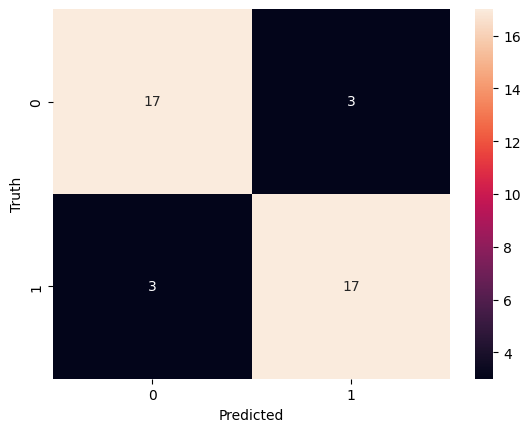

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.85      0.85      0.85        20

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40



In [31]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
y_pred = model.predict(reviews)

1/1 [==============================] - 2s 2s/step


In [32]:
y_pred= np.where(y_pred > 0.5, 1, 0)  # if y_predicted > 0.5 = 1 else 0
y_pred

array([[1],
       [1],
       [1],
       [0],
       [0]])